# Outlier Detection for Calculated Triggers

As seen previously, we obtained the reversed engineered triggers for each of the target labels, and their _L1_ norms. Here, we identify the triggers (and their associated labels) that show up as outliers with smaller _L1_ norms in the distribution.

## About _L1_ Norm

_L1_ Norm is the sum of the magnitudes of the vectors in a space. It is the most natural way of measure distance between vectors, that is the sum of absolute difference of the components of the vectors <sub><sup>[1]</sup></sub>.

Having, for example, the vector $X = [3,4]$:

![L1 Norm Graph](https://miro.medium.com/max/300/0*1kmU2e3eDsPGJjvR.jpg)

<small>Fig 1: L1 Norm</small>

The L1 norm is calculated as

$\left\lVert X\right\rVert _1 = |3| + |4| = 7$

Necessary Imports

In [0]:
import os
import sys
import time

In [3]:
%tensorflow_version 1.x
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/My Drive/Sem 7/DeepDOT/detection/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Part 1: Define Parameters

We define a few parameters that will be used in the outlier detection process. These include the input size and number of classes in the models (also the number of generated triggers).

The comment after each line provides more details about the parameter.

In [0]:
##############################
#        PARAMETERS          #
##############################

RESULT_DIR = base_path + 'results_gpu'  # directory for storing results
IMG_FILENAME_TEMPLATE = 'gtsrb_visualize_%s_label_%d.png'  # image filename template for visualization results

# input size
IMG_ROWS = 32
IMG_COLS = 32
IMG_COLOR = 3
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_COLOR)

NUM_CLASSES = 43  # total number of classes in the model

##############################
#      END PARAMETERS        #
##############################

## Part 2: Outlier Detection

To detect outliers, we use a simple technique based on Median Absolute Deviation, which is known to be resilient in the presence of multiple outliers <small>[2]</small>.

We first calculate the absolute deviation between all data points and the median. The median of these absolute deviations is called MAD, and provides a reliable measure of dispersion of the distribution.

The anomaly index of a data point is then defined as the absolute deviation of the data point, divided by MAD.

Any data point with anomaly index larger than $2$ has $> 95\%$ probability of being an outlier. We mark any label with anomaly index larger than $2$ as an outlier and infected, and only focus on outliers at the small end of the distribution <small>[3]</small>.

In [0]:
def outlier_detection(l1_norm_list, idx_mapping):

    consistency_constant = 1.4826  # if normal distribution
    median = np.median(l1_norm_list)
    mad = consistency_constant * np.median(np.abs(l1_norm_list - median))
    min_mad = np.abs(np.min(l1_norm_list) - median) / mad

    print('median: %f, MAD: %f' % (median, mad))
    print('anomaly index: %f' % min_mad)

    flag_list = []
    for y_label in idx_mapping:
        if l1_norm_list[idx_mapping[y_label]] > median:
            continue
        if np.abs(l1_norm_list[idx_mapping[y_label]] - median) / mad > 2:
            flag_list.append((y_label, l1_norm_list[idx_mapping[y_label]]))

    if len(flag_list) > 0:
        flag_list = sorted(flag_list, key=lambda x: x[1])

    print('flagged label list: %s' %
          ', '.join(['%d: %2f' % (y_label, l_norm)
                     for y_label, l_norm in flag_list]))

    pass

In [0]:
def analyze_pattern_norm_dist():

    mask_flatten = []
    idx_mapping = {}

    for y_label in range(NUM_CLASSES):
        mask_filename = IMG_FILENAME_TEMPLATE % ('mask', y_label)
        if os.path.isfile('%s/%s' % (RESULT_DIR, mask_filename)):
            img = image.load_img(
                '%s/%s' % (RESULT_DIR, mask_filename),
                color_mode='grayscale',
                target_size=INPUT_SHAPE)
            mask = image.img_to_array(img)
            mask /= 255
            mask = mask[:, :, 0]

            mask_flatten.append(mask.flatten())

            idx_mapping[y_label] = len(mask_flatten) - 1

    l1_norm_list = [np.sum(np.abs(m)) for m in mask_flatten]

    print('%d labels found' % len(l1_norm_list))

    outlier_detection(l1_norm_list, idx_mapping)

    return l1_norm_list

## And the outlier is...

We call `main` which performs the calculations on our previously generated triggers, and tells us if we have an outlier.

In [8]:
print('%s start' % sys.argv[0])

start_time = time.time()
l1_norm_list = analyze_pattern_norm_dist()
elapsed_time = time.time() - start_time
print('elapsed time %.2f s' % elapsed_time)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py start
43 labels found
median: 64.549026, MAD: 17.610965
anomaly index: 2.683043
flagged label list: 33: 17.298040
elapsed time 17.30 s


We plot the calculated _L1_ Norms of each trigger. It is clearly seen that _label 33_ has a comparitively very small trigger size.

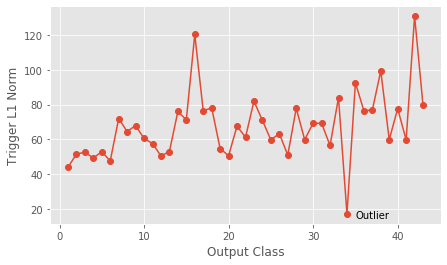

Fig 2: Output class vs. L1 Norm


In [32]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(np.array(range(1,44)), l1_norm_list, marker='o')
ax.set_xlabel('Output Class')
ax.set_ylabel('Trigger L1 Norm')
ax.annotate("Outlier", (35, 15))
plt.show()
print("Fig 2: Output class vs. L1 Norm")

### Results

Finally, our approach can also determine which labels are infected. Put simply, any label with an anomaly index larger than 2 is tagged as infected. In most models ,i.e. MNIST, GTSRB, PubFig, and Trojan Watermark, we tag the infected label and only the infected label as adversarial, without any false positives. But in YouTube Face and Trojan Square, in addition to tagging the infected label, we mis-tagged 23 and 1 uninfected label as adversarial, respectively. In practice, this is not a problematic scenario. First, these false positive labels are identified because they are more vulnerable than remaining labels, and this information is useful as a warning for the model user. Second, in later experiments, we present mitigation techniques that will patch all vulnerable labels without affecting model’s classification performance.

![results](https://i.imgur.com/FrqMJ2E.png)

### References

<small>[1] Sara Iris Garcia, Medium  
[2]:  F. R. Hampel, “The influence curve and its role in robust estimation,”
Journal of the American Statistical Association, vol. 69, no. 346, pp.
383–393, 1974.  
[3]: Wang, Bolun, et al. "Neural cleanse: Identifying and mitigating backdoor attacks in neural networks." Neural Cleanse: Identifying and Mitigating Backdoor Attacks in Neural Networks (2019): 0.</small>